In [9]:
from transformers import BertTokenizer, BertModel
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from transformers import AdamW
from transformers import get_scheduler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [10]:
class BertForRegression(nn.Module):
    def __init__(self, pretrained_model_name='bert-base-uncased', dropout=0.3):
        super(BertForRegression, self).__init__()
        self.bert = BertModel.from_pretrained(pretrained_model_name)
        hidden_size = self.bert.config.hidden_size  # 移到这里获取 hidden_size
        self.regressor = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 1),  # 输出一个数值
        )

    def forward(self, input_ids, attention_mask, token_type_ids=None):  # 修改：添加 token_type_ids 参数
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)  # 修改：传递 token_type_ids
        cls_output = outputs.last_hidden_state[:, 0, :]  # 取[CLS]标记对应的隐藏状态
        regression_output = self.regressor(cls_output)
        return regression_output

In [11]:
data = pd.read_csv('./data/mes_all.csv')
data = data[data['storypoint'] != -1]
data.drop_duplicates(inplace=True)
data.dropna(inplace=True)
data['text'] = data['title'] #+ '' + data['description']
data['storypoint'] = data['storypoint'].astype(float)

In [12]:
# 方差
data['storypoint'].var()

4.7259131664166

In [13]:
data['storypoint'].describe()

count    1197.000000
mean        2.655806
std         2.173917
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        13.000000
Name: storypoint, dtype: float64

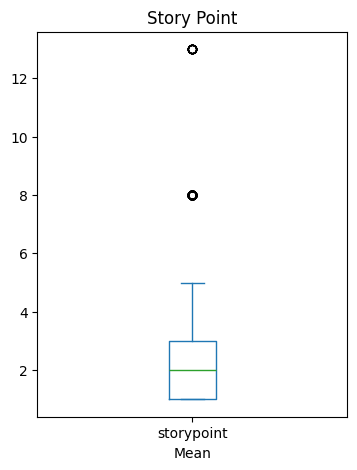

In [14]:
plt.figure(figsize=(4, 5)) 
data['storypoint'].plot(kind='box')
plt.title('Story Point')
plt.ylabel('')
plt.xlabel('Mean')
plt.show()

In [15]:
texts = data['text'].values.tolist()
labels = data['storypoint'].values.tolist()

split_point = int(len(data) * 0.8)
train_texts = texts[:split_point]
train_labels = labels[:split_point]
val_texts = texts[split_point:]
val_labels = labels[split_point:]

# 加载 BERT 分词器
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# 加载 BERT 模型，用于回归任务
model = BertForRegression()

# 分词函数
def tokenize_function(texts):
    return tokenizer(texts, padding="max_length", truncation=True, return_tensors="pt")

# 创建数据集字典
datasets = {
    "train": {"texts": train_texts, "labels": train_labels},
    "validation": {"texts": val_texts, "labels": val_labels}
}

# 将 tokenized_datasets 转换为 PyTorch Dataset
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# 分词
tokenized_train = tokenize_function(train_texts)
tokenized_val = tokenize_function(val_texts)

# 数据集
train_dataset = TextDataset(tokenized_train, train_labels)
val_dataset = TextDataset(tokenized_val, val_labels)

# 创建数据加载器
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)

# 设置优化器
optimizer = AdamW(model.parameters(), lr=2e-5)

# 设置学习率调度器
num_epochs = 2
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

# 将模型和优化器移动到 GPU（如果可用）
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# 训练模型
for epoch in range(num_epochs):
    model.train()
    progress_bar = tqdm(train_dataloader, desc=f"Training epoch {epoch+1}/{num_epochs}")
    for batch in progress_bar:
        # 将数据移到 GPU
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # 前向传播
        outputs = model(batch['input_ids'], batch['attention_mask'])
        loss = F.mse_loss(outputs, batch['labels'])
        
        # 反向传播
        loss.backward()
        
        # 更新参数
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        
        progress_bar.set_postfix({"loss": loss.item()})

    print(f"Epoch {epoch+1}/{num_epochs} completed.")

model.eval()
predictions = []
true_labels = []

# 在验证集上预测
for batch in val_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    
    with torch.no_grad():
        outputs = model(batch['input_ids'], batch['attention_mask'], token_type_ids=batch.get('token_type_ids'))  # 传递 token_type_ids
    
    predictions.extend(outputs.squeeze().cpu().numpy())  # 直接使用 outputs 作为预测结果
    true_labels.extend(batch["labels"].cpu().numpy())

# 计算 MAE
mae = mean_absolute_error(true_labels, predictions)
print(f"Mean Absolute Error: {mae:.4f}")

Training epoch 1/2: 100%|██████████| 30/30 [07:23<00:00, 14.77s/it, loss=3.98]


Epoch 1/2 completed.


Training epoch 2/2: 100%|██████████| 30/30 [07:21<00:00, 14.73s/it, loss=4.5] 


Epoch 2/2 completed.
Mean Absolute Error: 1.5632
